<div style="text-align:center; font-size:36px; font-weight:bold; color:#4A4A4A; background-color:#fff6e4; padding:10px; border:3px solid #f5ecda; border-radius:6px">
    Medical Cost Prediction
    <p style="text-align:center; font-size:14px; font-weight:normal; color:#4A4A4A; margin-top:12px;">
        Author: Jens Bender <br> 
        Created: December 2025<br>
        Last updated: January 2026
    </p>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Imports</h1>
</div>

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing (Scikit-learn)
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder
)

# Model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform  # for random hyperparameter values

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor 

# Model evaluation
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Loading and Inspection</h1>
</div>
<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Load the MEPS-HC 2023 data from the <code>h251.sas7bdat</code> file (SAS V9 format) into a Pandas DataFrame.
</div>

In [ ]:
try:
    # Load data using 'latin1' encoding because MEPS SAS files don't store text as UTF-8 and instead use Western European (ISO-8859-1), also known as latin1.
    df = pd.read_sas("../data/h251.sas7bdat", format="sas7bdat", encoding="latin1")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file content could not be parsed.")
except PermissionError:
    print("Error: Permission denied when accessing the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 📌 Initial data inspection to understand the structure of the dataset and detect obvious issues.</p>

In [ ]:
# Show DataFrame info to check the number of rows and columns, data types and missing values
df.info()

In [ ]:
# Show top five rows of the data
df.head()

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Preprocessing</h1>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Note:</strong> Kept column names in ALL CAPS in this project to ensure consistency with official <b><a href="../docs/references/h251doc.pdf">MEPS documentation</a></b>, <b><a href="../docs/references/h251cb.pdf">codebook</a></b>, and <b><a href="../docs/references/data_dictionary.md">data dictionary</a></b>.
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Duplicates</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify duplicates based on:
<ul>
    <li><strong>All columns</strong>: To detect exactly identical rows.</li>
    <li><strong>ID column only</strong>: To ensure that no two people share the same ID.</li>
    <li><strong>All columns except ID</strong>: To catch "hidden" duplicates where the same respondent may have been recorded twice under different IDs.</li>
</ul>
</div>

In [ ]:
# Identify duplicates based on all columns
df.duplicated().value_counts()

In [ ]:
# Identify duplicates based on the ID column
df.duplicated(["DUPERSID"]).value_counts()

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> ✅ No duplicates were found based on all columns or the ID column.</p>

In [ ]:
# Identify duplicates based on all columns except ID columns
id_columns = ["DUPERSID", "DUID", "PID", "PANEL"]
duplicates_without_id = df.duplicated(subset=df.columns.drop(id_columns), keep=False)
duplicates_without_id.value_counts()

In [ ]:
# Show duplicates
df[duplicates_without_id]

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    💡 <b>Insight:</b> Detected 3 pairs (6 rows) of respondents with identical values across all 1,300+ columns except for their IDs. 
    <p style="margin-top:10px; margin-bottom:0px">
        These appear to be young siblings (ages 1 and 5) from the same household with identical parent-reported health data, sample weights, and costs. Analysis suggests they are valid respondents rather than "ghost" records. Regardless, they will be excluded when filtering for the adult target population.
    </p>
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Variable Selection</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter the following 29 columns (out of 1,374):
    <ul style="margin-bottom:0px">
        <li><b>ID:</b> Unique identifier for each respondent (<code>DUPERSID</code>).</li>
        <li><b>Sample Weights:</b> Ensures population representativeness (<code>PERWT23F</code>).</li>
        <li><b>Candidate Features:</b> 26 variables selected for their consumer accessibility, beginning-of-year measurement, and predictive power.</li> 
        <li><b>Target Variable:</b> Total out-of-pocket health care costs (<code>TOTSLF23</code>).</li>
    </ul>
    <br>
    <b>Rationale:</b> For a detailed breakdown of the target variable selection and feature selection criteria, see the <b><a href="../docs/specs/technical_specifications.md">Technical Specifications</a></b> and <b><a href="../docs/research/candidate_features.md">Candidate Features Research</a></b>.
</div>

In [ ]:
# List of columns to keep 
columns_to_keep = [
    # 1. ID
    "DUPERSID",
    
    # 2. Sample Weights
    "PERWT23F", 

    # 3 Candidate Features.
    # 3.1 Demographics
    "AGE23X", "SEX", "REGION23", "MARRY31X",
    
    # 3.2 Socioeconomic
    "POVCAT23", "FAMSZE23", "HIDEG", "EMPST31",
    
    # 3.3 Insurance & Access
    "INSCOV23", "HAVEUS42",
    
    # 3.4 Perceived Health & Lifestyle
    "RTHLTH31", "MNHLTH31", "ADSMOK42",
    
    # 3.5 Limitations & Symptoms
    "ADLHLP31", "IADLHP31", "WLKLIM31", "COGLIM31", "JTPAIN31_M18",
    
    # 3.6 Chronic Conditions
    "HIBPDX", "CHOLDX", "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX", 
    
    # 4. Healthcare Expenditure (Target)
    "TOTSLF23"
]

# Drop all other columns (keeping 29 out of 1,374)
df = df[columns_to_keep]

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Filtering Target Population</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter rows to match the target population based on the following criteria:
    <ul style="margin-bottom:0px">
        <li><b>Positive person weight (<code>PERWT23F > 0</code>):</b> Drop respondents with a person weight of zero (i.e., 456 respondents). These individuals are considered "out-of-scope" for the full-year population (e.g., they joined the military, were institutionalized, or moved abroad).</li>
        <li><b>Adults (<code>AGE23X >= 18</code>):</b> Drop respondents under age 18 (i.e., 3796 respondents), as the medical cost planner app targets adults.</li>
    </ul>
    <br>
    <b>Note:</b> Keeps 14,768 out of 18,919 respondents.
</div>

In [ ]:
# Filter DataFrame 
df = df[(df["PERWT23F"] > 0) & (df["AGE23X"] >= 18)].copy() 

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Data Types</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify and convert incorrect storage data types.
    <ul>
        <li><b>ID:</b> <code>DUPERSID</code> is an identifier, not a quantity. Converting them to <code>string</code> prevents unintended math.</li>
        <li><b>Sample Weights:</b> <code>PERWT23F</code> contains decimal precision critical for population-level estimates. Must remain <code>float</code>.</li>
        <li><b>Candidate Features:</b> The SAS loader stored all 26 features as floats by default. Although many features are categorical and represent integer codes (e.g., 1=Male, 2=Female), they are maintained as <code>float</code> for three practical reasons:
            <ul>
                <li>Missing Value Compatibility: In standard Pandas, <code>np.nan</code> is a floating-point object. Assigning it to an integer column automatically casts back to <code>float64</code>.</li>
                <li>Data Preprocessing Consistency: scikit-learn transformers (e.g., <code>SimpleImputer</code>, <code>StandardScaler</code>) internally use floats and automatically convert numerical inputs to <code>float</code>, even when using <code>set_config(transform_output="pandas")</code>. Keeping them as floats avoids redundant type casting.</li>
                <li>Model Consistency: Most machine learning models (e.g., XGBoost, Linear Regression) internally use floats and automatically convert numerical inputs to <code>float</code> during training and inference. Keeping them as floats avoids redundant type casting.</li>
            </ul>
        </li>
        <li><b>Target Variable:</b> <code>TOTSLF23</code> is rounded to whole dollars in the raw MEPS data. It is kept as <code>float</code> for Model Consistency and to avoid redundant type casting, as ML models deliver <code>float</code> predictions during training and inference.</li>
    </ul>
</div>

In [ ]:
# Identify storage data types (defaulted to float/object by SAS loader)
df.dtypes

In [ ]:
# Convert ID to string
df["DUPERSID"] = df["DUPERSID"].astype(str)

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Standardizing Missing Values</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ <b>Pandas Missing Value Types</b>:
    <ul style="margin-bottom:0px">
        <li><b>np.nan:</b> Standard missing value indicator (technically a float); often the default in Pandas for numerical data.</li>
        <li><b>pd.NA:</b> Unified missing value indicator for modern nullable data types (mostly integer and boolean).</li>
        <li><b>None:</b> Python's native type; often used for object and string data.</li>
        <li><b>pd.NaT:</b> For datetime and timedelta data types.</li>
    </ul>
    <br>
    ℹ️ <b>MEPS Missing Value Codes:</b>
    <ul style="margin-bottom:0px">
        <li><b>-1 INAPPLICABLE:</b> Variable does not apply (structural skip).</li>
        <li><b>-7 REFUSED:</b> Person refused to answer.</li>
        <li><b>-8 DON'T KNOW:</b> Person did not know the answer.</li>
        <li><b>-9 NOT ASCERTAINED:</b> Administrative or technical error in collection.</li>
        <li><b>-15 CANNOT BE COMPUTED:</b> Incomplete data for a constructed variable.</li>
    </ul>
</div>

In [ ]:
# Identify Pandas missing values
df.isnull().sum()

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 <b>Handle MEPS-Specific Missing Values and Skip Patterns</b>
    <br><br>
    <b>Understanding Skip Patterns</b><br>
    Skip patterns (routing logic) are used in surveys to ensure respondents only answer questions relevant to them, reducing burden and improving data quality. For analysis, this creates "structural" missingness (coded as -1 Inapplicable) can often be recovered by looking at the respondent's path through the survey.
    <br><br>
    <b>Recovering Implied Values:</b>  
    <ul>
        <li><b>Smoker (<code>ADSMOK42</code>):</b> This question is only asked if the respondent already confirmed smoking 100+ cigarettes in their life. Those who said "No" skip this and are coded -1. In this project, these "Never Smokers" are mapped to "No" (2).</li>
        <li><b>Joint Pain (<code>JTPAIN31_M18</code>):</b> Respondents who already reported an arthritis diagnosis (<code>ARTHDX = 1</code>) earlier in the interview skip this question and are coded -1. Since arthritis inherently involves joint symptoms, these values are mapped to "Yes" (1).</li>
    </ul>
</div>

In [ ]:
# Recover implied values
# Smoker: Convert -1 (Never Smoker) to 2 (No)
df.loc[df["ADSMOK42"] == -1, "ADSMOK42"] = 2

# Joint Pain: Convert -1 to 1 (Yes) only if they have Arthritis 
df.loc[(df["JTPAIN31_M18"] == -1) & (df["ARTHDX"] == 1), "JTPAIN31_M18"] = 1

In [ ]:
# Identify MEPS missing values 
missing_codes = [-1, -7, -8, -9, -15]
missing_frequency_df = pd.DataFrame({code: (df == code).sum() for code in missing_codes})
missing_frequency_df["TOTAL"] = missing_frequency_df.sum(axis=1)
missing_frequency_df["PERCENTAGE"] = (missing_frequency_df["TOTAL"] / len(df) * 100).round(2)
missing_frequency_df.sort_values("TOTAL", ascending=False) 

In [ ]:
# Convert all MEPS missing codes to np.nan
df = df.replace(missing_codes, np.nan)

# Verify results
df.isnull().sum().sort_values(ascending=False)

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Train-Validation-Test Split</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px">
    📌 Split the data into 80% for training, 10% for validation, and 10% for testing.
    <table style="margin-left:0; margin-top:20px; margin-bottom:20px">
        <tr>
            <th style="background-color:#f5ecda;">Data</th>
            <th style="background-color:#f5ecda;">Size (%)</th>
            <th style="background-color:#f5ecda;">Size (Total)</th>
        </tr>
        <tr>
            <td style="background-color:#fff6e4;">Training Set</td>
            <td style="background-color:#fff6e4;">80%</td>
            <td style="background-color:#fff6e4;">11,814</td>
        </tr>
        <tr>
            <td style="background-color:#f5ecda;">Validation Set</td>
            <td style="background-color:#f5ecda;">10%</td>
            <td style="background-color:#f5ecda;">1,477</td>
        </tr>
        <tr>
            <td style="background-color:#fff6e4;">Test Set</td>
            <td style="background-color:#fff6e4;">10%</td>
            <td style="background-color:#fff6e4;">1,477</td>
        </tr>
    </table>
</div>

In [ ]:
# Split the data into X features and y target
X = df.drop("TOTSLF23", axis=1)
y = df["TOTSLF23"]

In [ ]:
# Split the data into training and temporary sets (80% train, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets (50% each)
# Note: This accomplishes a 80% training, 10% validation and 10% test set size
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Delete the temporary data to free up memory
del X_temp, y_temp

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Exploratory Data Analysis (EDA)</h1>
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Univariate EDA</h2>
</div>

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Analyze the distribution of a single column using descriptive statistics and visualizations.
</div>

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">Sample Weights</h3>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Examine descriptive statistics and visualize the distribution of the sample weights. 
</div>

In [ ]:
# Descriptive statistics of sample weights
df["PERWT23F"].describe()

In [ ]:
# Sum of sample weights
df["PERWT23F"].sum()

In [ ]:
# Histogram of sample weights
sns.histplot(df["PERWT23F"])

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px">
    💡 <b>Insight:</b> Using sample weights in machine learning models is essential to correct for oversampling and ensure that predictions are representative of the U.S. civilian noninstitutionalized adult population. 
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Sum:</b> The sum of all weights is approximately 260 million, representing the estimated U.S. adult population in 2023.</li>
        <li><b>Median:</b> A typical respondent represents roughly 14,600 people.</li>
        <li><b>Right-Skewed Distribution:</b> The mean (17,584) is higher than the median, confirming that a small number of respondents represent a disproportionately large share of the population.</li>
        <li><b>Sampling Strategy:</b> Weights range from 502 to 131,657. This reflects MEPS's strategy of oversampling specific subgroups to ensure reliable estimates for minority or high-need populations.</li>
        <li><b>Bias Correction:</b> Because weights vary significantly (std ≈ 12,334), unweighted models or averages would be biased. Using <code>sample_weight</code> during training ensures the model's loss function prioritizes population representativeness.</li>
    </ul>
</div>

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">Target Variable</h3>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Examine descriptive statistics (e.g., mean, median, standard deviation) and visualize the distribution (e.g., histograms) of total out-of-pocket health care costs.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Descriptive Statistics</strong> <br>
    📌 Examine descriptive statistics of total out-of-pocket health care costs. 
</div>

In [43]:
# Sample descriptive statistics (unweighted)
df["TOTSLF23"].describe()

count     14768.000000
mean       1159.541170
std        2994.288627
min           0.000000
25%          18.000000
50%         276.000000
75%        1119.000000
max      104652.000000
Name: TOTSLF23, dtype: float64

In [44]:
# Population descriptive statistics (weighted) 
weighted_mean = np.average(df["TOTSLF23"], weights=df["PERWT23F"])

np.float64(1105.9421421701202)

In [39]:
# Zero costs
zero_costs_summary = pd.DataFrame({
    "Count": [(df["TOTSLF23"] == 0).sum(), (df["TOTSLF23"] > 0).sum()],
    "Percentage": [
        (df["TOTSLF23"] == 0).mean() * 100,
        (df["TOTSLF23"] > 0).mean() * 100
    ]
}, index=["Zero Costs", "Positive Costs"]).round(2)
zero_costs_summary

,Count,Percentage
Zero Costs,3062,20.73
Positive Costs,11706,79.27


In [40]:
# Top 1% costs
top_1_cutoff = df["TOTSLF23"].quantile(0.99)
top_1_sum = df[df["TOTSLF23"] > top_1_cutoff]["TOTSLF23"].sum()
bottom_99_sum = df[df["TOTSLF23"] <= top_1_cutoff]["TOTSLF23"].sum()
top_1_share = top_1_sum / (top_1_sum + bottom_99_sum) * 100

print(f"The top 1% starts at: ${top_1_cutoff:,.0f}")
print(f"The top 1% have summed costs of: ${top_1_sum / 1_000_000:.1f}M")
print(f"The bottom 99% have summed costs of: ${bottom_99_sum / 1_000_000:.1f}M")
print(f"The top 1% of respondents account for {top_1_share:.0f}% of total out-of-pocket costs.")

The top 1% starts at: $13,055
The top 1% have summed costs of: $3.4M
The bottom 99% have summed costs of: $13.7M
The top 1% of respondents account for 20% of total out-of-pocket costs.


In [41]:
# Concentration of Out-of-Pocket Costs
percentiles = [0.99, 0.95, 0.9, 0.8, 0.5]
stats = []
total_spend = df["TOTSLF23"].sum()
for p in percentiles:
    cutoff = df["TOTSLF23"].quantile(p)
    spend_above = df[df["TOTSLF23"] > cutoff]["TOTSLF23"].sum()
    share = (spend_above / total_spend) * 100
    stats.append({
        "Top X%": f"Top {(1-p)*100:.0f}%",
        "Cutoff": f"${cutoff:,.0f}",
        "Share of Total Costs": f"{share:.0f}%"
    })
concentration_df = pd.DataFrame(stats)
concentration_df

,Top X%,Cutoff,Share of Total Costs
0,Top 1%,"$13,055",20%
1,Top 5%,"$4,824",45%
2,Top 10%,"$2,876",61%
3,Top 20%,"$1,512",79%
4,Top 50%,$276,97%


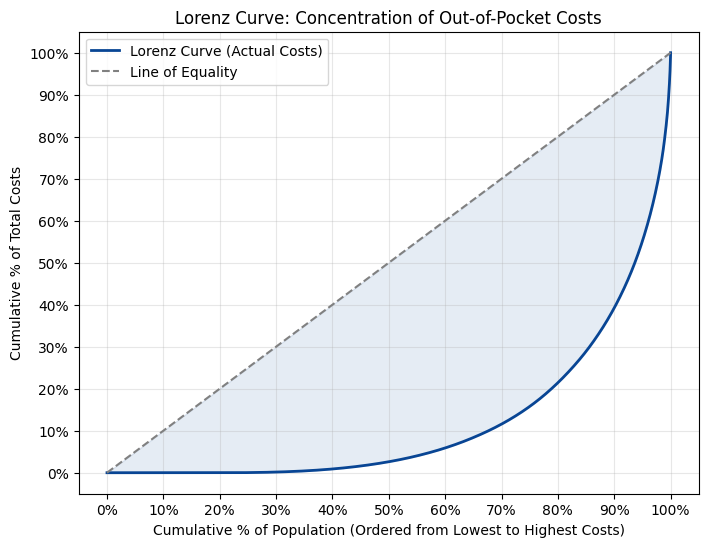

In [42]:
# Lorenz Curve
import matplotlib.ticker as mtick

# Sort costs from lowest to highest
sorted_costs = df["TOTSLF23"].sort_values()

# Calculate cumulative percentage of population and costs
cum_pop = np.arange(1, len(sorted_costs) + 1) / len(sorted_costs) * 100
cum_costs = sorted_costs.cumsum() / sorted_costs.sum() * 100

# Plotting
plt.figure(figsize=(8, 6))

# The Lorenz Curve
plt.plot(cum_pop, cum_costs, label="Lorenz Curve (Actual Costs)", color="#084594", lw=2)

# The Line of Equality (Perfectly equal spend)
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="Line of Equality")

# Fill the area for visual emphasis
plt.fill_between(cum_pop, cum_costs, cum_pop, color="#084594", alpha=0.1)

# Customization
plt.title("Lorenz Curve: Concentration of Out-of-Pocket Costs")
plt.xlabel("Cumulative % of Population (Ordered from Lowest to Highest Costs)")
plt.ylabel("Cumulative % of Total Costs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 101, 10))  # set grid lines every 10%
plt.yticks(range(0, 101, 10))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())  # format axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px">
    💡 <b>Insight:</b> High inequality in out-of-pocket health care spending.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Top 1% Concentration:</b> The top 1% of respondents account for 20% of total out-of-pocket costs.</li>
        <li><b>The 80/20 Rule:</b> The top 20% of respondents account for roughly 80% of total costs.</li>
        <li><b>Zero Costs:</b> 21% of respondents have $0 in out-of-pocket costs.</li>
        <li><b>Bottom 50%:</b> The bottom half of the population collectively accounts for less than 5% of total costs.</li>
    </ul>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Visualize Distributions</strong> <br> 
    📌 Histogram that shows the distribution of the target variable. 
</div>

In [ ]:
# Histogram of out-of-pocket costs
sns.histplot(df["TOTSLF23"])

In [ ]:
# Histogram of out-of-pocket costs excluding zero costs and top 1% 
sns.histplot(df[(df["TOTSLF23"] > 0) & (df["TOTSLF23"] <= top_1_cutoff)]["TOTSLF23"])